In [1]:
import pandas as pd

In [2]:
by_author = pd.read_csv('by_author')
by_author.columns = ['Author', 'commit']
by_author['commit'] = by_author['commit'].map(lambda x: x.split(','))
by_author.set_index('Author', inplace=True)
by_author = pd.melt(by_author['commit'].apply(pd.Series).reset_index(), 
            id_vars=['Author'],
            value_name='commit').sort_index()
by_author.drop('variable', axis=1, inplace=True)

In [3]:
offlist = by_author[['commit']].dropna()

In [21]:
df_repo.head()

,commit,date,author.name,author.email,files
0,bcf876870b95592b52519ed4aafcf9d95999bc9c,2020-08-02,Linus Torvalds,torvalds@linux-foundation.org,
1,5a30a78924ecd97b0335d2e1d3e01a5023c1a3d8,2020-08-02,Linus Torvalds,torvalds@linux-foundation.org,
2,142c3326b055a278c303bfef8dc6a105fff18ca6,2020-08-02,Linus Torvalds,torvalds@linux-foundation.org,
3,628e04dfeb4f66635c0d22cf1ad0cf427406e129,2020-08-02,Linus Torvalds,torvalds@linux-foundation.org,
4,28ab576ba8de934ee3145b6d75119f016de567cb,2020-08-02,Masahiro Yamada,masahiroy@kernel.org,scripts/Makefile.modpost


In [4]:
# Commit csv file generated from gitdm
df_repo = pd.read_csv('v5.7..v5.8_commits.csv', 
                      usecols=['commit','date','author.name','author.email', 'files'])\
                        .fillna('')
df_repo['date'] = pd.to_datetime(df_repo['date'])
# df_repo.head()

In [5]:
offlist = pd.merge(offlist, df_repo, how='left', on='commit')
# offlist.head()

In [6]:
from pypasta.LinuxMaintainers import LinuxMaintainers
from pypasta import Config

config = Config('linux')

repo = config.repo
all_maintainers = LinuxMaintainers(repo, revision='v5.8')

def check_if_maintainer(line):
    try:
        maintainers = []
        filenames = line['files'].split(',')
        for filename in filenames:
            sections = all_maintainers.get_sections_by_file(filename)
            sections -= {'THE REST'}
            for section in sections:
                _, mtrs, _ = all_maintainers.get_maintainers(section)
                maintainers += mtrs
        return line['author.name'].lower() in [x[0].lower() for x in maintainers]
    except:
        raise

offlist['author_is_maintainer'] = offlist.apply(check_if_maintainer, axis=1)

How many of the off-list commits were nade by maintainers:

In [7]:
offlist['author_is_maintainer'].value_counts()

False    693
True     417
Name: author_is_maintainer, dtype: int64

MINDATE = 2019-05-31

MAXDATE = 2020-08-02

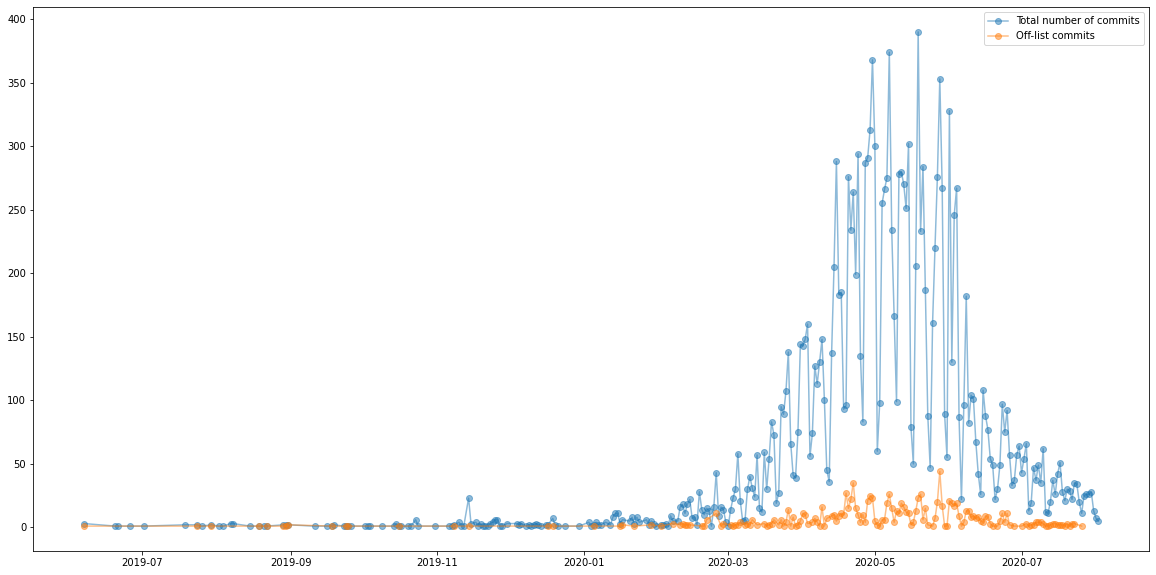

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))

mask = (df_repo['date'] > '2019-05-31') & (df_repo['date'] <= '2020-08-02')

# Plot total number of commits
ax.plot(df_repo.loc[mask].groupby('date').count().reset_index()['date'],
        df_repo.loc[mask].groupby('date').count().reset_index()['commit'],
        marker='o', alpha=0.5)

# Plot the number of off-list commits
ax.plot(offlist[mask].groupby('date').count().reset_index()['date'],
        offlist[mask].groupby('date').count().reset_index()['commit'],
        marker='o', alpha=0.5)

ax.legend(['Total number of commits', 'Off-list commits'])

ax.figure.savefig('total_vs_off-list_by_time.pdf', bbox_inches = "tight")

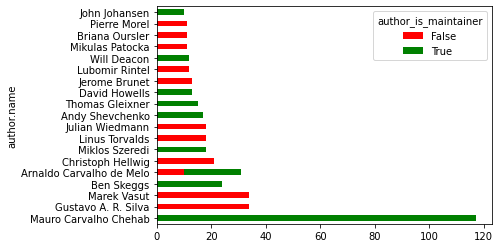

In [9]:
ax = offlist.groupby('author.name')['author_is_maintainer']\
        .value_counts()\
        .sort_values(ascending=False)[:20]\
        .unstack()\
        .plot.barh(stacked=True, color=['r','g'])

ax.figure.savefig('top_off-list_authors.pdf', bbox_inches = "tight")

In [10]:
repo_authors = df_repo.groupby('author.name')\
                        .nunique()['commit']\
                        .reset_index()
offlist_authors = offlist.groupby(['author.name'])\
                            .nunique()['commit']\
                            .reset_index()
authors = pd.merge(repo_authors, offlist_authors, on='author.name', how='left').fillna(0)
authors['offlist (%)'] = authors.apply(lambda x: 100*x['commit_y']/(x['commit_x']), axis=1)

In [11]:
authors.sort_values('commit_y', ascending=False)[:20]

,author.name,commit_x,commit_y,offlist (%)
1136,Mauro Carvalho Chehab,550,123.0,22.363636
592,Gustavo A. R. Silva,136,34.0,25.000000
1071,Marek Vasut,59,34.0,57.627119
158,Arnaldo Carvalho de Melo,83,31.0,37.349398
200,Ben Skeggs,29,24.0,82.758621
304,Christoph Hellwig,354,22.0,6.214689
127,Andy Shevchenko,226,20.0,8.849558
1198,Miklos Szeredi,37,19.0,51.351351
989,Linus Torvalds,482,18.0,3.734440
855,Julian Wiedmann,37,18.0,48.648649


In [12]:
# authors.sort_values('offlist (%)', ascending=False)[:20].plot.barh(x='author.name', y='offlist (%)')

In [13]:
# authors.sort_values('commit_y', ascending=False)[:20].plot.barh(x='author.name', y='offlist (%)')

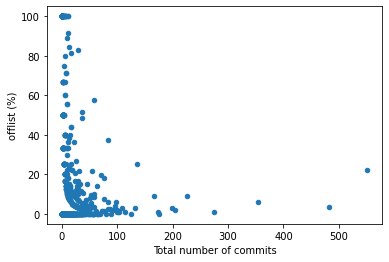

In [14]:
ax = authors.plot.scatter(x='commit_x', y='offlist (%)')
ax.set_xlabel('Total number of commits')
ax.figure.savefig('total_vs_off-list_percentage.pdf', bbox_inches = "tight")

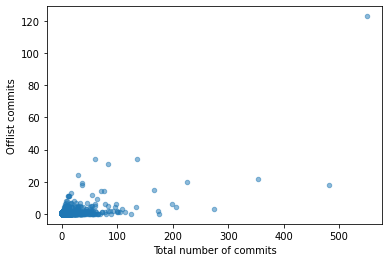

In [15]:
ax = authors.plot.scatter(x='commit_x', y='commit_y', alpha=0.5)

ax.set_xlabel('Total number of commits')
ax.set_ylabel('Offlist commits')

ax.figure.savefig('total_vs_off-list.pdf', bbox_inches = "tight")

In [16]:
authors[['commit_x', 'commit_y']].corr()

,commit_x,commit_y
commit_x,1.000000,0.644273
commit_y,0.644273,1.000000


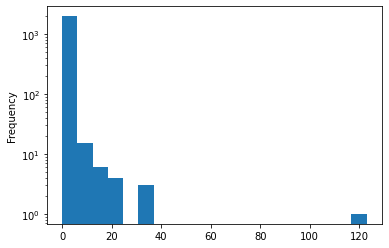

In [17]:
authors['commit_y'].plot.hist(bins=20, logy=True)